In [1]:
import xarray as xr
import dask
import zarr
import timeit
import time
import os
import random

In [2]:
# Open the NetCDF file using xarray
file_path = '2m_temperature-day-mean.nc'
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset> Size: 121GB
Dimensions:    (time: 14610, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 117kB 1984-01-01 1984-01-02 ... 2023-12-31
Data variables:
    t2m        (time, latitude, longitude) float64 121GB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-30 17:50:29 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [4]:
# File size on disk
file_size_bytes = os.path.getsize(file_path)
file_size_gb = file_size_bytes / (1024**3)
print(f"The size of the file is {file_size_gb:.2f} GB")
# Dataset size in memeory
memory_size_bytes = ds.nbytes
memory_size_gb = memory_size_bytes / (1024**3)
print(f"The dataset size in memory is approximately {memory_size_gb:.2f} GB")

The size of the file is 28.25 GB
The dataset size in memory is approximately 113.02 GB


In [3]:
# Access the variable (e.g., 't2m')
t2m = ds['t2m']
t2m

<xarray.DataArray 't2m' (time: 14610, latitude: 721, longitude: 1440)> Size: 121GB
[15168686400 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 117kB 1984-01-01 1984-01-02 ... 2023-12-31
Attributes:
    units:      K
    long_name:  2 metre temperature

**Slicing Using Zarr (1/5/2025)**

Cube Chunk 

In [5]:
# Slicing the data into 200x200x200 cubes
cube_chunks= ds.chunk({'time': 200, 'latitude': 200, 'longitude': 200}).t2m
print(cube_chunks.chunks)

((200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 10), (200, 200, 200, 121), (200, 200, 200, 200, 200, 200, 200, 40))


In [6]:
first_chunk = cube_chunks.isel(time=slice(0, 200), latitude=slice(0, 200), longitude=slice(0, 200)).compute()
print(first_chunk)

<xarray.DataArray 't2m' (time: 200, latitude: 200, longitude: 200)> Size: 64MB
array([[[248.72569322, 248.72569322, 248.72569322, ..., 248.72569322,
         248.72569322, 248.72569322],
        [248.65922374, 248.65922374, 248.65922374, ..., 248.74719805,
         248.74719805, 248.74719805],
        [248.63771891, 248.63771891, 248.63576393, ..., 248.69636845,
         248.69832343, 248.70027842],
        ...,
        [280.52742761, 280.54893244, 280.58216717, ..., 287.25843956,
         287.26234953, 287.24866464],
        [280.78548557, 280.79721548, 280.83045022, ..., 287.30926916,
         287.31317913, 287.31513412],
        [281.04940849, 281.06504837, 281.12369791, ..., 287.35423381,
         287.35618879, 287.35814378]],

       [[246.48528087, 246.48528087, 246.48528087, ..., 246.48528087,
         246.48528087, 246.48528087],
        [246.24481777, 246.24481777, 246.24481777, ..., 246.45400112,
         246.4559561 , 246.4559561 ],
        [246.27609752, 246.27414254, 246.2

In [7]:
# Slicing the data into 500x500x500 cubes
cube_chunks= ds.chunk({'time': 500, 'latitude': 500, 'longitude': 500}).t2m
print(cube_chunks.chunks)
# Saving the slices into a Zarr file
cube_chunks.to_zarr('cube.zarr', mode='w')

((500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 110), (500, 221), (500, 500, 440))


In [6]:
def get_dir_size_in_mb(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size / (1024 * 1024)  

In [7]:
zarr_file_path= 'cube.zarr'
zarr_size_mb = get_dir_size_in_mb(zarr_file_path)
print(f"Size of the Zarr file: {zarr_size_mb:.2f} MB")

Size of the Zarr file: 20912.79 MB


Using the random query

In [4]:
#Function to generate a random query of a certain number of dimensions
def gen_random_query(n_time, n_lat, n_lon, max_time=14610, max_lat=721, max_lon=1440):   
    
    time_start = random.randint(0, max_time - n_time)
    lat_start = random.randint(0, max_lat - n_lat)
    lon_start = random.randint(0, max_lon - n_lon)

    time_slice = slice(time_start, time_start + n_time)
    lat_slice = slice(lat_start, lat_start + n_lat)
    lon_slice = slice(lon_start, lon_start + n_lon)

    return time_slice, lat_slice, lon_slice


In [48]:
#Labels and Time variables to help in plotting bar charts
cube_labels=[]
cube_times=[]
vertical_labels=[]
vertical_times=[]
horizontal_labels=[]
horizontal_times=[]
file_labels=[]
file_times=[]

In [49]:
#Cube query on cube (61.04 MB)
time_slice, lat_slice, lon_slice = gen_random_query(200, 200, 200)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

zarr_data = xr.open_zarr('cube.zarr')
start = time.time()
c_result1 = zarr_data.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
cube_labels.append('Cube')
cube_times.append(execution_time)
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = c_result1.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
c_result1

Time Slice: slice(9752, 9952, None)
Latitude Slice: slice(407, 607, None)
Longitude Slice: slice(405, 605, None)
Execution time: 6.436504364013672 s 
Accessed data size: 61.04 MB


<xarray.Dataset> Size: 64MB
Dimensions:    (latitude: 200, longitude: 200, time: 200)
Coordinates:
  * latitude   (latitude) float32 800B -11.75 -12.0 -12.25 ... -61.25 -61.5
  * longitude  (longitude) float32 800B -78.75 -78.5 -78.25 ... -29.25 -29.0
  * time       (time) datetime64[ns] 2kB 2010-09-13 2010-09-14 ... 2011-03-31
Data variables:
    t2m        (time, latitude, longitude) float64 64MB 288.7 288.5 ... 272.4

In [13]:
#aggregate function (max) inspection
max_temp = zarr_data['t2m'].max().compute()
print(max_temp)

KeyboardInterrupt: 

In [50]:
#Vertical query on cube (61.04 MB)
time_slice, lat_slice, lon_slice = gen_random_query(512, 125, 125)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

equal = xr.open_zarr('cube.zarr')
start = time.time()
c_result2 = equal.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
cube_labels.append('Vertical')
cube_times.append(execution_time)
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = c_result2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
c_result2

Time Slice: slice(4934, 5446, None)
Latitude Slice: slice(589, 714, None)
Longitude Slice: slice(1226, 1351, None)
Execution time: 1.758162021636963 s 
Accessed data size: 61.04 MB


<xarray.Dataset> Size: 64MB
Dimensions:    (latitude: 125, longitude: 125, time: 512)
Coordinates:
  * latitude   (latitude) float32 500B -57.25 -57.5 -57.75 ... -88.0 -88.25
  * longitude  (longitude) float32 500B 126.5 126.8 127.0 ... 157.0 157.2 157.5
  * time       (time) datetime64[ns] 4kB 1997-07-05 1997-07-06 ... 1998-11-28
Data variables:
    t2m        (time, latitude, longitude) float64 64MB 273.7 273.8 ... 240.8

In [51]:
#Horizontal query on cube (61.04 MB)
time_slice, lat_slice, lon_slice = gen_random_query(50, 400, 400)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

equal = xr.open_zarr('cube.zarr')
start = time.time()
c_result3 = equal.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
cube_labels.append('Horizontal')
cube_times.append(execution_time)
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = c_result3.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
c_result3

Time Slice: slice(5860, 5910, None)
Latitude Slice: slice(254, 654, None)
Longitude Slice: slice(793, 1193, None)
Execution time: 5.04161524772644 s 
Accessed data size: 61.04 MB


<xarray.Dataset> Size: 64MB
Dimensions:    (latitude: 400, longitude: 400, time: 50)
Coordinates:
  * latitude   (latitude) float32 2kB 26.5 26.25 26.0 ... -72.75 -73.0 -73.25
  * longitude  (longitude) float32 2kB 18.25 18.5 18.75 ... 117.5 117.8 118.0
  * time       (time) datetime64[ns] 400B 2000-01-17 2000-01-18 ... 2000-03-06
Data variables:
    t2m        (time, latitude, longitude) float64 64MB 282.4 282.0 ... 232.4

In [18]:
#Cube query on cube (7.63 MB)
time_slice, lat_slice, lon_slice = gen_random_query(100, 100, 100)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

equal = xr.open_zarr('equal_2.zarr')
start = time.time()
c_result4 = equal.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = c_result4.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
c_result4

Time Slice: slice(13993, 14093, None)
Latitude Slice: slice(254, 354, None)
Longitude Slice: slice(1220, 1320, None)
Execution time: 2.4686710834503174 s 
Accessed data size: 7.63 MB


<xarray.Dataset> Size: 8MB
Dimensions:    (latitude: 100, longitude: 100, time: 100)
Coordinates:
  * latitude   (latitude) float32 400B 26.5 26.25 26.0 25.75 ... 2.25 2.0 1.75
  * longitude  (longitude) float32 400B 125.0 125.2 125.5 ... 149.2 149.5 149.8
  * time       (time) datetime64[ns] 800B 2022-04-24 2022-04-25 ... 2022-08-01
Data variables:
    t2m        (time, latitude, longitude) float64 8MB 298.6 298.7 ... 300.7

In [19]:
#Vertical query on cube (7.63 MB)
time_slice, lat_slice, lon_slice = gen_random_query(400, 50, 50)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

equal = xr.open_zarr('equal_2.zarr')
start = time.time()
c_result5 = equal.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = c_result5.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
c_result5

Time Slice: slice(5575, 5975, None)
Latitude Slice: slice(615, 665, None)
Longitude Slice: slice(900, 950, None)
Execution time: 0.7823808193206787 s 
Accessed data size: 7.63 MB


<xarray.Dataset> Size: 8MB
Dimensions:    (latitude: 50, longitude: 50, time: 400)
Coordinates:
  * latitude   (latitude) float32 200B -63.75 -64.0 -64.25 ... -75.75 -76.0
  * longitude  (longitude) float32 200B 45.0 45.25 45.5 ... 56.75 57.0 57.25
  * time       (time) datetime64[ns] 3kB 1999-04-07 1999-04-08 ... 2000-05-10
Data variables:
    t2m        (time, latitude, longitude) float64 8MB 268.5 268.5 ... 221.4

In [20]:
#Horizontal query on cube (7.63 MB)
time_slice, lat_slice, lon_slice = gen_random_query(25, 200, 200)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

equal = xr.open_zarr('equal_2.zarr')
start = time.time()
c_result6 = equal.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = c_result6.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
c_result6

Time Slice: slice(2461, 2486, None)
Latitude Slice: slice(436, 636, None)
Longitude Slice: slice(641, 841, None)
Execution time: 1.6353940963745117 s 
Accessed data size: 7.63 MB


<xarray.Dataset> Size: 8MB
Dimensions:    (latitude: 200, longitude: 200, time: 25)
Coordinates:
  * latitude   (latitude) float32 800B -19.0 -19.25 -19.5 ... -68.5 -68.75
  * longitude  (longitude) float32 800B -19.75 -19.5 -19.25 ... 29.5 29.75 30.0
  * time       (time) datetime64[ns] 200B 1990-09-27 1990-09-28 ... 1990-10-21
Data variables:
    t2m        (time, latitude, longitude) float64 8MB 295.2 295.2 ... 267.0

In [10]:
# Slicing the data into 50x50x50 cubes
cube_chunks= ds.chunk({'time': 50, 'latitude': 50, 'longitude': 50}).t2m
print(cube_chunks.chunks)
# Saving the slices into a Zarr file
cube_chunks.to_zarr('equal_3.zarr', mode='w')

((50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50

Vertical Cuboid Chunks

In [ ]:
# Slicing the data into 100x100x800 vertical cuboids
v_cuboids_chunks= ds.chunk({'time': 800, 'latitude': 100, 'longitude': 100}).t2m
print(v_cuboids_chunks.chunks)
# Saving the slices into a Zarr file
v_cuboids_chunks.to_zarr('vertical_1.zarr', mode='w')

In [11]:
# Slicing the data into 1000x300x300 vertical cuboids
v_cuboids_chunks= ds.chunk({'time': 1000, 'latitude': 300, 'longitude': 300}).t2m
print(v_cuboids_chunks.chunks)
# Saving the slices into a Zarr file
v_cuboids_chunks.to_zarr('vertical_2.zarr', mode='w')

((1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 610), (300, 300, 121), (300, 300, 300, 300, 240))


In [12]:
zarr_file_path= 'vertical_2.zarr'
zarr_size_mb = get_dir_size_in_mb(zarr_file_path)
print(f"Size of the Zarr file: {zarr_size_mb:.2f} MB")

Size of the Zarr file: 20971.16 MB


In [52]:
#Cube query on vertical (61.04 MB)
time_slice, lat_slice, lon_slice = gen_random_query(200, 200, 200)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

vertical = xr.open_zarr('vertical_2.zarr')
start = time.time()
v_result1 = vertical.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
vertical_labels.append('Cube')
vertical_times.append(execution_time)
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = v_result1.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
v_result1

Time Slice: slice(5169, 5369, None)
Latitude Slice: slice(3, 203, None)
Longitude Slice: slice(883, 1083, None)
Execution time: 3.0558791160583496 s 
Accessed data size: 61.04 MB


<xarray.Dataset> Size: 64MB
Dimensions:    (latitude: 200, longitude: 200, time: 200)
Coordinates:
  * latitude   (latitude) float32 800B 89.25 89.0 88.75 88.5 ... 40.0 39.75 39.5
  * longitude  (longitude) float32 800B 40.75 41.0 41.25 ... 90.0 90.25 90.5
  * time       (time) datetime64[ns] 2kB 1998-02-25 1998-02-26 ... 1998-09-12
Data variables:
    t2m        (time, latitude, longitude) float64 64MB 251.0 251.0 ... 294.9

In [53]:
#Vertical query on vertical (61.04 MB)
time_slice, lat_slice, lon_slice = gen_random_query(512, 125, 125)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

vertical = xr.open_zarr('vertical_2.zarr')
start = time.time()
v_result2 = vertical.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
vertical_labels.append('Vertical')
vertical_times.append(execution_time)
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = v_result2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
v_result2

Time Slice: slice(13674, 14186, None)
Latitude Slice: slice(181, 306, None)
Longitude Slice: slice(415, 540, None)
Execution time: 4.780092000961304 s 
Accessed data size: 61.04 MB


<xarray.Dataset> Size: 64MB
Dimensions:    (latitude: 125, longitude: 125, time: 512)
Coordinates:
  * latitude   (latitude) float32 500B 44.75 44.5 44.25 ... 14.25 14.0 13.75
  * longitude  (longitude) float32 500B -76.25 -76.0 -75.75 ... -45.5 -45.25
  * time       (time) datetime64[ns] 4kB 2021-06-09 2021-06-10 ... 2022-11-02
Data variables:
    t2m        (time, latitude, longitude) float64 64MB 294.9 294.6 ... 300.5

In [54]:
#Horizontal query on vertical (61.04 MB)
time_slice, lat_slice, lon_slice = gen_random_query(50, 400, 400)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

vertical = xr.open_zarr('vertical_2.zarr')
start = time.time()
v_result3 = vertical.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
vertical_labels.append('Horizontal')
vertical_times.append(execution_time)
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = v_result3.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
v_result3

Time Slice: slice(14210, 14260, None)
Latitude Slice: slice(73, 473, None)
Longitude Slice: slice(275, 675, None)
Execution time: 3.0218260288238525 s 
Accessed data size: 61.04 MB


<xarray.Dataset> Size: 64MB
Dimensions:    (latitude: 400, longitude: 400, time: 50)
Coordinates:
  * latitude   (latitude) float32 2kB 71.75 71.5 71.25 ... -27.5 -27.75 -28.0
  * longitude  (longitude) float32 2kB -111.2 -111.0 -110.8 ... -11.75 -11.5
  * time       (time) datetime64[ns] 400B 2022-11-27 2022-11-28 ... 2023-01-15
Data variables:
    t2m        (time, latitude, longitude) float64 64MB 242.0 242.1 ... 295.4

In [ ]:
#Cube query on vertical (7.63 MB)
time_slice, lat_slice, lon_slice = gen_random_query(100, 100, 100)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

vertical = xr.open_zarr('vertical_2.zarr')
start = time.time()
v_result4 = vertical.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = v_result4.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
v_result4

In [24]:
#Vertical query on vertical (7.63 MB)
time_slice, lat_slice, lon_slice = gen_random_query(400, 50, 50)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

vertical = xr.open_zarr('vertical_2.zarr')
start = time.time()
v_result5 = vertical.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = v_result5.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
v_result5

Time Slice: slice(9292, 9692, None)
Latitude Slice: slice(266, 316, None)
Longitude Slice: slice(699, 749, None)
Execution time: 1.5966131687164307 s 
Accessed data size: 7.63 MB


<xarray.Dataset> Size: 8MB
Dimensions:    (latitude: 50, longitude: 50, time: 400)
Coordinates:
  * latitude   (latitude) float32 200B 23.5 23.25 23.0 ... 11.75 11.5 11.25
  * longitude  (longitude) float32 200B -5.25 -5.0 -4.75 -4.5 ... 6.5 6.75 7.0
  * time       (time) datetime64[ns] 3kB 2009-06-10 2009-06-11 ... 2010-07-14
Data variables:
    t2m        (time, latitude, longitude) float64 8MB 303.1 303.5 ... 298.4

In [ ]:
#Horizontal query on vertical (7.63 MB)
time_slice, lat_slice, lon_slice = gen_random_query(25, 200, 200)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

horizontal = xr.open_zarr('vertical_2.zarr')
start = time.time()
h_result6 = horizontal.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = h_result6.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
h_result6

In [20]:
#Horizontal query on vertical (7.63 MB)
vertical = xr.open_zarr('vertical_2.zarr')
start = time.time()
v_result6 = vertical.isel(time=slice(0, 25), latitude=slice(0, 200), longitude=slice(0, 200)).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = v_result6.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
v_result6

Execution time: 1.1663577556610107 s 
Accessed data size: 7.63 MB


<xarray.Dataset> Size: 8MB
Dimensions:    (latitude: 200, longitude: 200, time: 25)
Coordinates:
  * latitude   (latitude) float32 800B 90.0 89.75 89.5 ... 40.75 40.5 40.25
  * longitude  (longitude) float32 800B -180.0 -179.8 -179.5 ... -130.5 -130.2
  * time       (time) datetime64[ns] 200B 1984-01-01 1984-01-02 ... 1984-01-25
Data variables:
    t2m        (time, latitude, longitude) float64 8MB 248.7 248.7 ... 284.8

In [13]:
#Vertical query on vertical
equal = xr.open_zarr('vertical_2.zarr')
start = time.time()
v_result2 = equal.isel(time=slice(0, 400), latitude=slice(0, 50), longitude=slice(0, 50)).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = v_result2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
v_result2


Execution time: 0.9372696876525879 s 
Accessed data size: 7.63 MB


<xarray.Dataset> Size: 8MB
Dimensions:    (latitude: 50, longitude: 50, time: 400)
Coordinates:
  * latitude   (latitude) float32 200B 90.0 89.75 89.5 ... 78.25 78.0 77.75
  * longitude  (longitude) float32 200B -180.0 -179.8 -179.5 ... -168.0 -167.8
  * time       (time) datetime64[ns] 3kB 1984-01-01 1984-01-02 ... 1985-02-03
Data variables:
    t2m        (time, latitude, longitude) float64 8MB 248.7 248.7 ... 249.1

In [14]:
#Horizontal query on vertical 
equal = xr.open_zarr('vertical_2.zarr')
start = time.time()
v_result3 = equal.isel(time=slice(0, 50), latitude=slice(0, 350), longitude=slice(0, 350)).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = v_result3.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
v_result3

Execution time: 2.7350900173187256 s 
Accessed data size: 46.73 MB


<xarray.Dataset> Size: 49MB
Dimensions:    (latitude: 350, longitude: 350, time: 50)
Coordinates:
  * latitude   (latitude) float32 1kB 90.0 89.75 89.5 89.25 ... 3.25 3.0 2.75
  * longitude  (longitude) float32 1kB -180.0 -179.8 -179.5 ... -93.0 -92.75
  * time       (time) datetime64[ns] 400B 1984-01-01 1984-01-02 ... 1984-02-19
Data variables:
    t2m        (time, latitude, longitude) float64 49MB 248.7 248.7 ... 298.6

In [11]:
# Slicing the data into 300x30x30 vertical cuboids
v_cuboids_chunks= ds.chunk({'time': 300, 'latitude': 30, 'longitude': 30}).t2m
print(v_cuboids_chunks.chunks)
# Saving the slices into a Zarr file
v_cuboids_chunks.to_zarr('vertical_3.zarr', mode='w')

((300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 210), (30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 1), (30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30))


Horizontal Cuboid Chunks

In [ ]:
# Slicing the data into 400x40x50 horizontal cuboids
h_cuboids_chunks= ds.chunk({'time': 50, 'latitude': 400, 'longitude': 400}).t2m
print(h_cuboids_chunks.chunks)
# Saving the slices into a Zarr file
h_cuboids_chunks.to_zarr('equal.zarr', mode='w')

In [13]:
# Slicing the data into 100x700x700 horizontal cuboids
h_cuboids_chunks= ds.chunk({'time': 100, 'latitude': 700, 'longitude': 700}).t2m
print(h_cuboids_chunks.chunks)
# Saving the slices into a Zarr file
h_cuboids_chunks.to_zarr('horizontal_2.zarr', mode='w')

((100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10), (700, 21), (700, 700, 40))


In [14]:
zarr_file_path= 'horizontal_2.zarr'
zarr_size_mb = get_dir_size_in_mb(zarr_file_path)
print(f"Size of the Zarr file: {zarr_size_mb:.2f} MB")

Size of the Zarr file: 21056.63 MB


In [55]:
#Cube query on horizontal (61.04 MB)
time_slice, lat_slice, lon_slice = gen_random_query(200, 200, 200)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)
horizontal = xr.open_zarr('horizontal_2.zarr')
start = time.time()
h_result1 = horizontal.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
horizontal_labels.append('Cube')
horizontal_times.append(execution_time)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = h_result1.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
h_result1





Time Slice: slice(8820, 9020, None)
Latitude Slice: slice(16, 216, None)
Longitude Slice: slice(612, 812, None)
Execution time: 3.9951326847076416 s 
Accessed data size: 61.04 MB


<xarray.Dataset> Size: 64MB
Dimensions:    (latitude: 200, longitude: 200, time: 200)
Coordinates:
  * latitude   (latitude) float32 800B 86.0 85.75 85.5 ... 36.75 36.5 36.25
  * longitude  (longitude) float32 800B -27.0 -26.75 -26.5 ... 22.25 22.5 22.75
  * time       (time) datetime64[ns] 2kB 2008-02-24 2008-02-25 ... 2008-09-10
Data variables:
    t2m        (time, latitude, longitude) float64 64MB 245.9 245.9 ... 300.0

In [56]:
#Vertical query on horizontal (61.04 MB)
time_slice, lat_slice, lon_slice = gen_random_query(512, 125, 125)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)
horizontal = xr.open_zarr('horizontal_2.zarr')
start = time.time()
h_result2 = horizontal.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
horizontal_labels.append('Vertical')
horizontal_times.append(execution_time)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = h_result2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
h_result2

Time Slice: slice(7102, 7614, None)
Latitude Slice: slice(313, 438, None)
Longitude Slice: slice(1265, 1390, None)
Execution time: 4.199653148651123 s 
Accessed data size: 61.04 MB


<xarray.Dataset> Size: 64MB
Dimensions:    (latitude: 125, longitude: 125, time: 512)
Coordinates:
  * latitude   (latitude) float32 500B 11.75 11.5 11.25 ... -18.75 -19.0 -19.25
  * longitude  (longitude) float32 500B 136.2 136.5 136.8 ... 166.8 167.0 167.2
  * time       (time) datetime64[ns] 4kB 2003-06-12 2003-06-13 ... 2004-11-04
Data variables:
    t2m        (time, latitude, longitude) float64 64MB 300.1 300.1 ... 297.8

In [57]:
#Horizontal query on horizontal (61.04 MB)
time_slice, lat_slice, lon_slice = gen_random_query(50, 400, 400)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)
horizontal = xr.open_zarr('horizontal_2.zarr')
start = time.time()
h_result3 = horizontal.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
horizontal_labels.append('Horizontal')
horizontal_times.append(execution_time)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = h_result3.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
h_result3

Time Slice: slice(1460, 1510, None)
Latitude Slice: slice(61, 461, None)
Longitude Slice: slice(309, 709, None)
Execution time: 2.8580377101898193 s 
Accessed data size: 61.04 MB


<xarray.Dataset> Size: 64MB
Dimensions:    (latitude: 400, longitude: 400, time: 50)
Coordinates:
  * latitude   (latitude) float32 2kB 74.75 74.5 74.25 ... -24.5 -24.75 -25.0
  * longitude  (longitude) float32 2kB -102.8 -102.5 -102.2 ... -3.5 -3.25 -3.0
  * time       (time) datetime64[ns] 400B 1987-12-31 1988-01-01 ... 1988-02-18
Data variables:
    t2m        (time, latitude, longitude) float64 64MB 249.3 249.1 ... 296.7

In [39]:
cube_times=cube_times[3:]
cube_labels=cube_labels[3:]
vertical_times=vertical_times[3:]
vertical_labels=vertical_labels[3:]
horizontal_times=horizontal_times[3:]
horizontal_labels=horizontal_labels[3:]
for i in range(3):
    print ("Cube times= ",cube_times[i])
    print ("Vertical times= ",vertical_times[i])
    print ("Horizontal times= ",horizontal_times[i])


Cube times=  5.6636316776275635
Vertical times=  3.7403228282928467
Horizontal times=  4.7998366355896
Cube times=  4.21396541595459
Vertical times=  2.166311025619507
Horizontal times=  4.579137086868286
Cube times=  3.1390154361724854
Vertical times=  13.115817546844482
Horizontal times=  1.4921751022338867


## Plotting Bar Charts

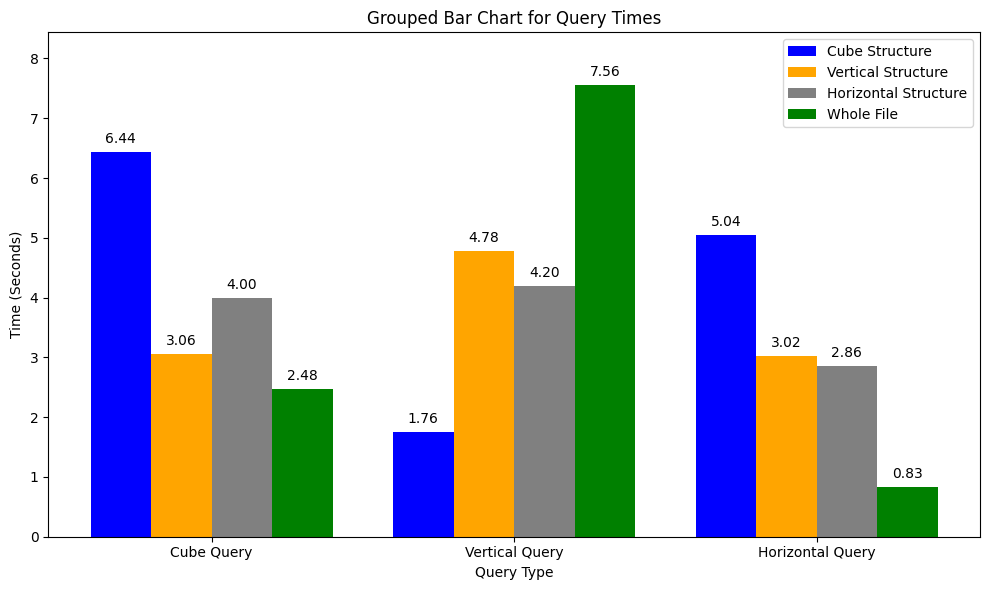

In [61]:
import matplotlib.pyplot as plt
import numpy as np

queries = ['Cube Query', 'Vertical Query', 'Horizontal Query']
x = np.arange(len(queries))  
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - 1.5 * width, cube_times, width, label='Cube Structure', color='blue')
bars2 = ax.bar(x - 0.5 * width, vertical_times, width, label='Vertical Structure', color='orange')
bars3 = ax.bar(x + 0.5 * width, horizontal_times, width, label='Horizontal Structure', color='gray')
bars4 = ax.bar(x + 1.5 * width, file_times, width, label='Whole File', color='green')
# Adding text annotations with exact heights
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,  
            bar.get_height() + 0.1,            
            f'{bar.get_height():.2f}',         
            ha='center', va='bottom'          
        )

# Customize chart
ax.set_xlabel('Query Type')
ax.set_ylabel('Time (Seconds)')
ax.set_title('Grouped Bar Chart for Query Times')
ax.set_xticks(x)
ax.set_xticklabels(queries)
ax.set_ylim(0, max(max(cube_times), max(vertical_times), max(horizontal_times)) + 2)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [24]:
#Cube query on horizontal (7.63 MB)
horizontal = xr.open_zarr('horizontal_2.zarr')
start = time.time()
h_result4 = horizontal.isel(time=slice(0, 100), latitude=slice(0, 100), longitude=slice(0, 100)).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = h_result4.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
h_result4


Execution time: 0.6334841251373291 s 
Accessed data size: 7.63 MB


<xarray.Dataset> Size: 8MB
Dimensions:    (latitude: 100, longitude: 100, time: 100)
Coordinates:
  * latitude   (latitude) float32 400B 90.0 89.75 89.5 ... 65.75 65.5 65.25
  * longitude  (longitude) float32 400B -180.0 -179.8 -179.5 ... -155.5 -155.2
  * time       (time) datetime64[ns] 800B 1984-01-01 1984-01-02 ... 1984-04-09
Data variables:
    t2m        (time, latitude, longitude) float64 8MB 248.7 248.7 ... 249.8

In [25]:
#Vertical query on horizontal (7.63 MB)
horizontal = xr.open_zarr('horizontal_2.zarr')
start = time.time()
h_result5 = horizontal.isel(time=slice(0, 400), latitude=slice(0, 50), longitude=slice(0, 50)).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = h_result5.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
h_result5

Execution time: 1.3296327590942383 s 
Accessed data size: 7.63 MB


<xarray.Dataset> Size: 8MB
Dimensions:    (latitude: 50, longitude: 50, time: 400)
Coordinates:
  * latitude   (latitude) float32 200B 90.0 89.75 89.5 ... 78.25 78.0 77.75
  * longitude  (longitude) float32 200B -180.0 -179.8 -179.5 ... -168.0 -167.8
  * time       (time) datetime64[ns] 3kB 1984-01-01 1984-01-02 ... 1985-02-03
Data variables:
    t2m        (time, latitude, longitude) float64 8MB 248.7 248.7 ... 249.1

In [26]:
#Horizontal query on horizontal (7.63 MB)
horizontal = xr.open_zarr('horizontal_2.zarr')
start = time.time()
h_result6 = horizontal.isel(time=slice(0, 25), latitude=slice(0, 200), longitude=slice(0, 200)).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = h_result6.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
h_result6

Execution time: 0.6162328720092773 s 
Accessed data size: 7.63 MB


<xarray.Dataset> Size: 8MB
Dimensions:    (latitude: 200, longitude: 200, time: 25)
Coordinates:
  * latitude   (latitude) float32 800B 90.0 89.75 89.5 ... 40.75 40.5 40.25
  * longitude  (longitude) float32 800B -180.0 -179.8 -179.5 ... -130.5 -130.2
  * time       (time) datetime64[ns] 200B 1984-01-01 1984-01-02 ... 1984-01-25
Data variables:
    t2m        (time, latitude, longitude) float64 8MB 248.7 248.7 ... 284.8

In [27]:
#Vertical query on horizontal
equal = xr.open_zarr('horizontal_2.zarr')
start = time.time()
h_result2 = equal.isel(time=slice(0, 400), latitude=slice(0, 50), longitude=slice(0, 50)).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = h_result2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

Execution time: 1.4270591735839844 s 
Accessed data size: 7.63 MB


In [ ]:
# Slicing the data into 1000x300x300 vertical cuboids
v_cuboids_chunks= ds.chunk({'time': 1000, 'latitude': 300, 'longitude': 300}).t2m
print(v_cuboids_chunks.chunks)
# Saving the slices into a Zarr file
v_cuboids_chunks.to_zarr('vertical_2.zarr', mode='w')

((1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 610), (300, 300, 121), (300, 300, 300, 300, 240))


In [18]:
#Horizontal query on horizontal
equal = xr.open_zarr('horizontal_2.zarr')
start = time.time()
h_result3 = equal.isel(time=slice(0, 50), latitude=slice(0, 350), longitude=slice(0, 350)).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = v_result3.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
h_result3

Execution time: 0.49286842346191406 s 
Accessed data size: 46.73 MB


<xarray.Dataset> Size: 49MB
Dimensions:    (latitude: 350, longitude: 350, time: 50)
Coordinates:
  * latitude   (latitude) float32 1kB 90.0 89.75 89.5 89.25 ... 3.25 3.0 2.75
  * longitude  (longitude) float32 1kB -180.0 -179.8 -179.5 ... -93.0 -92.75
  * time       (time) datetime64[ns] 400B 1984-01-01 1984-01-02 ... 1984-02-19
Data variables:
    t2m        (time, latitude, longitude) float64 49MB 248.7 248.7 ... 298.6

In [12]:
# Slicing the data into 10x200x200 horizontal cuboids
h_cuboids_chunks= ds.chunk({'time': 10, 'latitude': 200, 'longitude': 200}).t2m
print(h_cuboids_chunks.chunks)
# Saving the slices into a Zarr file
h_cuboids_chunks.to_zarr('horizontal_3.zarr', mode='w')

((10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

In [6]:
start = time.time()
horizontal = xr.open_zarr('horizontal_3.zarr')
h_result = horizontal.isel(time=slice(0, 5), latitude=slice(0, 100), longitude=slice(0, 100)).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")
print(h_result)
#Calculating the size of the accessed data
accessed_size_bytes = h_result.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")


Execution time: 0.0725247859954834 s 
<xarray.Dataset> Size: 401kB
Dimensions:    (latitude: 100, longitude: 100, time: 5)
Coordinates:
  * latitude   (latitude) float32 400B 90.0 89.75 89.5 ... 65.75 65.5 65.25
  * longitude  (longitude) float32 400B -180.0 -179.8 -179.5 ... -155.5 -155.2
  * time       (time) datetime64[ns] 40B 1984-01-01 1984-01-02 ... 1984-01-05
Data variables:
    t2m        (time, latitude, longitude) float64 400kB 248.7 248.7 ... 248.1
Accessed data size: 0.38 MB


Original File Queries

In [58]:
#Cube query on whole NetCDF file (61.04 MB)
time_slice, lat_slice, lon_slice = gen_random_query(200, 200, 200)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

start = time.time()
f_result1 = ds.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
file_labels.append('Cube')
file_times.append(execution_time)
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = f_result1.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
f_result1

Time Slice: slice(9581, 9781, None)
Latitude Slice: slice(367, 567, None)
Longitude Slice: slice(902, 1102, None)
Execution time: 2.476654291152954 s 
Accessed data size: 61.04 MB


<xarray.Dataset> Size: 64MB
Dimensions:    (time: 200, latitude: 200, longitude: 200)
Coordinates:
  * longitude  (longitude) float32 800B 45.5 45.75 46.0 ... 94.75 95.0 95.25
  * latitude   (latitude) float32 800B -1.75 -2.0 -2.25 ... -51.0 -51.25 -51.5
  * time       (time) datetime64[ns] 2kB 2010-03-26 2010-03-27 ... 2010-10-11
Data variables:
    t2m        (time, latitude, longitude) float64 64MB 302.1 302.1 ... 276.1
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-30 17:50:29 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [59]:
#Vertical query on whole NetCDF file (61.04 MB)
time_slice, lat_slice, lon_slice = gen_random_query(512, 125, 125)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

start = time.time()
f_result2 = ds.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
file_labels.append('Vertical')
file_times.append(execution_time)
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = f_result2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
f_result2

Time Slice: slice(363, 875, None)
Latitude Slice: slice(490, 615, None)
Longitude Slice: slice(50, 175, None)
Execution time: 7.563917875289917 s 
Accessed data size: 61.04 MB


<xarray.Dataset> Size: 64MB
Dimensions:    (time: 512, latitude: 125, longitude: 125)
Coordinates:
  * longitude  (longitude) float32 500B -167.5 -167.2 -167.0 ... -136.8 -136.5
  * latitude   (latitude) float32 500B -32.5 -32.75 -33.0 ... -63.0 -63.25 -63.5
  * time       (time) datetime64[ns] 4kB 1984-12-29 1984-12-30 ... 1986-05-24
Data variables:
    t2m        (time, latitude, longitude) float64 64MB 293.0 292.9 ... 273.4
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-30 17:50:29 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [60]:
#Horizontal query on whole NetCDF file (61.04 MB)
time_slice, lat_slice, lon_slice = gen_random_query(50, 400, 400)

print("Time Slice:", time_slice)
print("Latitude Slice:", lat_slice)
print("Longitude Slice:", lon_slice)

start = time.time()
f_result3 = ds.isel(time=time_slice, latitude=lat_slice, longitude=lon_slice).compute()
end = time.time()
execution_time = end - start
file_labels.append('Horizontal')
file_times.append(execution_time)
print(f"Execution time: {execution_time} s ")

#Calculating the size of the accessed data
accessed_size_bytes = f_result3.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
f_result3

Time Slice: slice(4858, 4908, None)
Latitude Slice: slice(300, 700, None)
Longitude Slice: slice(420, 820, None)
Execution time: 0.8298745155334473 s 
Accessed data size: 61.04 MB


<xarray.Dataset> Size: 64MB
Dimensions:    (time: 50, latitude: 400, longitude: 400)
Coordinates:
  * longitude  (longitude) float32 2kB -75.0 -74.75 -74.5 ... 24.25 24.5 24.75
  * latitude   (latitude) float32 2kB 15.0 14.75 14.5 ... -84.25 -84.5 -84.75
  * time       (time) datetime64[ns] 400B 1997-04-20 1997-04-21 ... 1997-06-08
Data variables:
    t2m        (time, latitude, longitude) float64 64MB 299.0 299.0 ... 217.0
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-30 17:50:29 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [31]:
#Cube query on whole NetCDF file (7.63 MB)
start = time.time()
f_result4 = ds.isel(time=slice(0, 100), latitude=slice(0, 100), longitude=slice(0, 100)).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = f_result4.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
f_result4

Execution time: 0.02720785140991211 s 
Accessed data size: 7.63 MB


<xarray.Dataset> Size: 8MB
Dimensions:    (time: 100, latitude: 100, longitude: 100)
Coordinates:
  * longitude  (longitude) float32 400B -180.0 -179.8 -179.5 ... -155.5 -155.2
  * latitude   (latitude) float32 400B 90.0 89.75 89.5 ... 65.75 65.5 65.25
  * time       (time) datetime64[ns] 800B 1984-01-01 1984-01-02 ... 1984-04-09
Data variables:
    t2m        (time, latitude, longitude) float64 8MB 248.7 248.7 ... 249.8
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-30 17:50:29 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [32]:
#Vertical query on whole NetCDF file (7.63 MB)
start = time.time()
f_result5 = ds.isel(time=slice(0, 400), latitude=slice(0, 50), longitude=slice(0, 50)).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = f_result5.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
f_result5

Execution time: 0.032549142837524414 s 
Accessed data size: 7.63 MB


<xarray.Dataset> Size: 8MB
Dimensions:    (time: 400, latitude: 50, longitude: 50)
Coordinates:
  * longitude  (longitude) float32 200B -180.0 -179.8 -179.5 ... -168.0 -167.8
  * latitude   (latitude) float32 200B 90.0 89.75 89.5 ... 78.25 78.0 77.75
  * time       (time) datetime64[ns] 3kB 1984-01-01 1984-01-02 ... 1985-02-03
Data variables:
    t2m        (time, latitude, longitude) float64 8MB 248.7 248.7 ... 249.1
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-30 17:50:29 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [33]:
#Horizontal query on whole NetCDF file (7.63 MB)
start = time.time()
f_result6 = ds.isel(time=slice(0, 25), latitude=slice(0, 200), longitude=slice(0, 200)).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = f_result6.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
f_result6

Execution time: 0.025729894638061523 s 
Accessed data size: 7.63 MB


<xarray.Dataset> Size: 8MB
Dimensions:    (time: 25, latitude: 200, longitude: 200)
Coordinates:
  * longitude  (longitude) float32 800B -180.0 -179.8 -179.5 ... -130.5 -130.2
  * latitude   (latitude) float32 800B 90.0 89.75 89.5 ... 40.75 40.5 40.25
  * time       (time) datetime64[ns] 200B 1984-01-01 1984-01-02 ... 1984-01-25
Data variables:
    t2m        (time, latitude, longitude) float64 8MB 248.7 248.7 ... 284.8
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-30 17:50:29 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [25]:
#Vertical query on whole NetCDF file
start = time.time()
f_result2 = ds.isel(time=slice(0, 400), latitude=slice(0, 50), longitude=slice(0, 50)).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = f_result2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
f_result2

Execution time: 1.7010314464569092 s 
Accessed data size: 7.63 MB


<xarray.Dataset> Size: 8MB
Dimensions:    (time: 400, latitude: 50, longitude: 50)
Coordinates:
  * longitude  (longitude) float32 200B -180.0 -179.8 -179.5 ... -168.0 -167.8
  * latitude   (latitude) float32 200B 90.0 89.75 89.5 ... 78.25 78.0 77.75
  * time       (time) datetime64[ns] 3kB 1984-01-01 1984-01-02 ... 1985-02-03
Data variables:
    t2m        (time, latitude, longitude) float64 8MB 248.7 248.7 ... 249.1
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-30 17:50:29 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [26]:
#Horizontal query on whole NetCDF file
start = time.time()
f_result3 = ds.isel(time=slice(0, 50), latitude=slice(0, 350), longitude=slice(0, 350)).compute()
end = time.time()
execution_time = end - start
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = f_result3.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")
f_result3

Execution time: 0.05241513252258301 s 
Accessed data size: 46.73 MB


<xarray.Dataset> Size: 49MB
Dimensions:    (time: 50, latitude: 350, longitude: 350)
Coordinates:
  * longitude  (longitude) float32 1kB -180.0 -179.8 -179.5 ... -93.0 -92.75
  * latitude   (latitude) float32 1kB 90.0 89.75 89.5 89.25 ... 3.25 3.0 2.75
  * time       (time) datetime64[ns] 400B 1984-01-01 1984-01-02 ... 1984-02-19
Data variables:
    t2m        (time, latitude, longitude) float64 49MB 248.7 248.7 ... 298.6
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-30 17:50:29 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

**Slicing Using NetCDF**

Cube Chunk (200x200x200)

In [4]:
#First cube chunk (0, 200)
cube_chunk1 = t2m.isel(latitude=slice(0, 200), longitude=slice(0, 200), time=slice(0, 200)).compute()
cube_chunk1
cube_chunk1.to_netcdf('cube1.nc')

In [5]:
#Second cube chunk (200, 400)
cube_chunk2 = t2m.isel(latitude=slice(200, 400), longitude=slice(200, 400), time=slice(200, 400)).compute()
cube_chunk2
cube_chunk2.to_netcdf('cube2.nc')

In [6]:
#Third cube chunk (400, 600)
cube_chunk3 = t2m.isel(latitude=slice(400, 600), longitude=slice(400, 600), time=slice(400, 600)).compute()
cube_chunk3
cube_chunk3.to_netcdf('cube3.nc')

In [7]:
#Size of all cube chuncks

for i in range (3):
    file_path= f"cube{i+1}.nc"
    file_size_bytes = os.path.getsize(file_path)
    print(f"Cube {i+1} size on disk: {file_size_bytes / (1024**2):.2f} MB")
    
    


Cube 1 size on disk: 15.27 MB
Cube 2 size on disk: 15.27 MB
Cube 3 size on disk: 15.27 MB


In [8]:
#Range query using the cube access pattern on the first cube chunk
start = time.time()
q1_ds = xr.open_dataset('cube1.nc')
q1 = q1_ds.isel(time=slice(0, 50), latitude=slice(0, 50), longitude=slice(0, 50)).compute()
end = time.time()
execution_time = end - start
print(q1)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q1.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 1MB
Dimensions:    (longitude: 50, latitude: 50, time: 50)
Coordinates:
  * longitude  (longitude) float32 200B -180.0 -179.8 -179.5 ... -168.0 -167.8
  * latitude   (latitude) float32 200B 90.0 89.75 89.5 ... 78.25 78.0 77.75
  * time       (time) datetime64[ns] 400B 1984-01-01 1984-01-02 ... 1984-02-19
Data variables:
    t2m        (time, latitude, longitude) float64 1MB 248.7 248.7 ... 245.6
Execution time: 0.025914907455444336 s 
Accessed data size: 0.95 MB


In [ ]:
q1

In [9]:
#Range query using the cube access pattern on the second cube chunk
start = time.time()
q1_ds = xr.open_dataset('cube2.nc')
q1 = q1_ds.isel(time=slice(0, 50), latitude=slice(0, 50), longitude=slice(0, 50)).compute()
end = time.time()
execution_time = end - start
print(q1)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q1.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 1MB
Dimensions:    (longitude: 50, latitude: 50, time: 50)
Coordinates:
  * longitude  (longitude) float32 200B -130.0 -129.8 -129.5 ... -118.0 -117.8
  * latitude   (latitude) float32 200B 40.0 39.75 39.5 ... 28.25 28.0 27.75
  * time       (time) datetime64[ns] 400B 1984-07-19 1984-07-20 ... 1984-09-06
Data variables:
    t2m        (time, latitude, longitude) float64 1MB 287.7 287.7 ... 295.7
Execution time: 0.024009227752685547 s 
Accessed data size: 0.95 MB


In [10]:
#Range query using the cube access pattern on the third cube chunk
start = time.time()
q1_ds = xr.open_dataset('cube3.nc')
q1 = q1_ds.isel(time=slice(0, 50), latitude=slice(0, 50), longitude=slice(0, 50)).compute()
end = time.time()
execution_time = end - start
print(q1)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q1.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 1MB
Dimensions:    (longitude: 50, latitude: 50, time: 50)
Coordinates:
  * longitude  (longitude) float32 200B -80.0 -79.75 -79.5 ... -68.0 -67.75
  * latitude   (latitude) float32 200B -10.0 -10.25 -10.5 ... -22.0 -22.25
  * time       (time) datetime64[ns] 400B 1985-02-04 1985-02-05 ... 1985-03-25
Data variables:
    t2m        (time, latitude, longitude) float64 1MB 296.4 296.1 ... 276.1
Execution time: 0.03533434867858887 s 
Accessed data size: 0.95 MB


In [ ]:
#Merge queries from the same file
start = time.time()
cube_ds_list = []
cube_ds = xr.open_dataset('cube1.nc')
for i in range(1, 50):
    cube_query = cube_ds.isel(time=slice(0, i), latitude=slice(0, i), longitude=slice(0, i)).compute()
    cube_ds_list.append(cube_query)
cube_result = xr.merge(cube_ds_list).compute()
end = time.time()
execution_time = end - start
print(cube_result)
execution_time

In [ ]:
#Merge query results from different files
start = time.time()
cube_ds_list = []
cube_files = ['cube1.nc', 'cube2.nc', 'cube3.nc']
for file in cube_files:
    cube_ds = xr.open_dataset(file)
    cube_query = cube_ds.isel(time=slice(0, 50), latitude=slice(0, 50), longitude=slice(0, 50)).compute()
    cube_ds_list.append(cube_query)
merge_cube_result = xr.merge(cube_ds_list).compute()
end = time.time()
execution_time = end - start
print(merge_cube_result)
execution_time

In [ ]:
merge_cube_result

NAN values because of different dimension values.
 
For example, if one chunk has latitude values from 0 to 199, and another chunk has latitude values from 200 to 399, xarray will not automatically align them, leading to NaN values where the coordinates do not match.

In [23]:
#Range query using the vertical cuboid access pattern on the first cube chunk
#(10x10x40)
start = time.time()
q2_ds = xr.open_dataset('cube1.nc')
q2 = q2_ds.isel(time=slice(0, 40), latitude=slice(0, 10), longitude=slice(0, 10)).compute()
end = time.time()
execution_time = end - start
print(q2)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 32kB
Dimensions:    (longitude: 10, latitude: 10, time: 40)
Coordinates:
  * longitude  (longitude) float32 40B -180.0 -179.8 -179.5 ... -178.0 -177.8
  * latitude   (latitude) float32 40B 90.0 89.75 89.5 89.25 ... 88.25 88.0 87.75
  * time       (time) datetime64[ns] 320B 1984-01-01 1984-01-02 ... 1984-02-09
Data variables:
    t2m        (time, latitude, longitude) float64 32kB 248.7 248.7 ... 243.9
Execution time: 0.016068220138549805 s 
Accessed data size: 0.03 MB


In [29]:
#Range query using the vertical cuboid access pattern on the first cube chunk
#(40x40x100)
start = time.time()
q2_ds = xr.open_dataset('cube1.nc')
q2 = q2_ds.isel(time=slice(0, 100), latitude=slice(0, 40), longitude=slice(0, 40)).compute()
end = time.time()
execution_time = end - start
print(q2)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 1MB
Dimensions:    (longitude: 40, latitude: 40, time: 100)
Coordinates:
  * longitude  (longitude) float32 160B -180.0 -179.8 -179.5 ... -170.5 -170.2
  * latitude   (latitude) float32 160B 90.0 89.75 89.5 ... 80.75 80.5 80.25
  * time       (time) datetime64[ns] 800B 1984-01-01 1984-01-02 ... 1984-04-09
Data variables:
    t2m        (time, latitude, longitude) float64 1MB 248.7 248.7 ... 247.3
Execution time: 0.028816938400268555 s 
Accessed data size: 1.22 MB


In [24]:
#Range query using the vertical cuboid access pattern on the second cube chunk
#(10x10x40)
start = time.time()
q2_ds = xr.open_dataset('cube2.nc')
q2 = q2_ds.isel(time=slice(0, 40), latitude=slice(0, 10), longitude=slice(0, 10)).compute()
end = time.time()
execution_time = end - start
print(q2)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 32kB
Dimensions:    (longitude: 10, latitude: 10, time: 40)
Coordinates:
  * longitude  (longitude) float32 40B -130.0 -129.8 -129.5 ... -128.0 -127.8
  * latitude   (latitude) float32 40B 40.0 39.75 39.5 39.25 ... 38.25 38.0 37.75
  * time       (time) datetime64[ns] 320B 1984-07-19 1984-07-20 ... 1984-08-27
Data variables:
    t2m        (time, latitude, longitude) float64 32kB 287.7 287.7 ... 290.6
Execution time: 0.04691886901855469 s 
Accessed data size: 0.03 MB


In [30]:
#Range query using the vertical cuboid access pattern on the second cube chunk
#(40x40x100)
start = time.time()
q2_ds = xr.open_dataset('cube2.nc')
q2 = q2_ds.isel(time=slice(0, 100), latitude=slice(0, 40), longitude=slice(0, 40)).compute()
end = time.time()
execution_time = end - start
print(q2)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 1MB
Dimensions:    (longitude: 40, latitude: 40, time: 100)
Coordinates:
  * longitude  (longitude) float32 160B -130.0 -129.8 -129.5 ... -120.5 -120.2
  * latitude   (latitude) float32 160B 40.0 39.75 39.5 ... 30.75 30.5 30.25
  * time       (time) datetime64[ns] 800B 1984-07-19 1984-07-20 ... 1984-10-26
Data variables:
    t2m        (time, latitude, longitude) float64 1MB 287.7 287.7 ... 290.8
Execution time: 0.028264760971069336 s 
Accessed data size: 1.22 MB


In [35]:
#Range query using the horizontal cuboid access pattern on the first cube chunk
#(100x100x25)
start = time.time()
q3_ds = xr.open_dataset('cube1.nc')
q3 = q3_ds.isel(time=slice(0, 25), latitude=slice(0, 100), longitude=slice(0, 100)).compute()
end = time.time()
execution_time = end - start
print(q3)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q3.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 2MB
Dimensions:    (longitude: 100, latitude: 100, time: 25)
Coordinates:
  * longitude  (longitude) float32 400B -180.0 -179.8 -179.5 ... -155.5 -155.2
  * latitude   (latitude) float32 400B 90.0 89.75 89.5 ... 65.75 65.5 65.25
  * time       (time) datetime64[ns] 200B 1984-01-01 1984-01-02 ... 1984-01-25
Data variables:
    t2m        (time, latitude, longitude) float64 2MB 248.7 248.7 ... 235.8
Execution time: 0.029001951217651367 s 
Accessed data size: 1.91 MB


In [36]:
#Range query using the horizontal cuboid access pattern on the second cube chunk
#(100x100x25)
start = time.time()
q3_ds = xr.open_dataset('cube2.nc')
q3 = q3_ds.isel(time=slice(0, 25), latitude=slice(0, 100), longitude=slice(0, 100)).compute()
end = time.time()
execution_time = end - start
print(q3)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q3.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 2MB
Dimensions:    (longitude: 100, latitude: 100, time: 25)
Coordinates:
  * longitude  (longitude) float32 400B -130.0 -129.8 -129.5 ... -105.5 -105.2
  * latitude   (latitude) float32 400B 40.0 39.75 39.5 ... 15.75 15.5 15.25
  * time       (time) datetime64[ns] 200B 1984-07-19 1984-07-20 ... 1984-08-12
Data variables:
    t2m        (time, latitude, longitude) float64 2MB 287.7 287.7 ... 300.2
Execution time: 0.023001670837402344 s 
Accessed data size: 1.91 MB


Vertical Cuboid (100x100x800)

In [13]:
#First cuboid chunk 
cuboidv_chunk1 = t2m.isel(latitude=slice(0, 100), longitude=slice(0, 100), time=slice(0, 800)).compute()
cuboidv_chunk1
cuboidv_chunk1.to_netcdf('cuboidv1.nc')

In [14]:
#Second cuboid chunk 
cuboidv_chunk1 = t2m.isel(latitude=slice(100, 200), longitude=slice(100, 200), time=slice(800, 1600)).compute()
cuboidv_chunk1
cuboidv_chunk1.to_netcdf('cuboidv2.nc')

In [15]:
#Size of all cuboid chuncks

for i in range (2):
    file_path= f"cuboidv{i+1}.nc"
    file_size_bytes = os.path.getsize(file_path)
    print(f"Cuboid {i+1} size on disk: {file_size_bytes / (1024**2):.2f} MB")

Cuboid 1 size on disk: 15.27 MB
Cuboid 2 size on disk: 15.27 MB


In [16]:
#Range query using the cube access pattern on the first vertical cuboid chunk
start = time.time()
q1_ds = xr.open_dataset('cuboidv1.nc')
q1 = q1_ds.isel(time=slice(0, 50), latitude=slice(0, 50), longitude=slice(0, 50)).compute()
end = time.time()
execution_time = end - start
print(q1)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q1.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 1MB
Dimensions:    (longitude: 50, latitude: 50, time: 50)
Coordinates:
  * longitude  (longitude) float32 200B -180.0 -179.8 -179.5 ... -168.0 -167.8
  * latitude   (latitude) float32 200B 90.0 89.75 89.5 ... 78.25 78.0 77.75
  * time       (time) datetime64[ns] 400B 1984-01-01 1984-01-02 ... 1984-02-19
Data variables:
    t2m        (time, latitude, longitude) float64 1MB 248.7 248.7 ... 245.6
Execution time: 0.03468918800354004 s 
Accessed data size: 0.95 MB


In [17]:
#Range query using the cube access pattern on the second vertical cuboid chunk
start = time.time()
q1_ds = xr.open_dataset('cuboidv2.nc')
q1 = q1_ds.isel(time=slice(0, 50), latitude=slice(0, 50), longitude=slice(0, 50)).compute()
end = time.time()
execution_time = end - start
print(q1)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q1.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 1MB
Dimensions:    (longitude: 50, latitude: 50, time: 50)
Coordinates:
  * longitude  (longitude) float32 200B -155.0 -154.8 -154.5 ... -143.0 -142.8
  * latitude   (latitude) float32 200B 65.0 64.75 64.5 ... 53.25 53.0 52.75
  * time       (time) datetime64[ns] 400B 1986-03-11 1986-03-12 ... 1986-04-29
Data variables:
    t2m        (time, latitude, longitude) float64 1MB 253.9 254.0 ... 279.0
Execution time: 0.014892578125 s 
Accessed data size: 0.95 MB


In [25]:
#Range query using the vertical cuboid access pattern on the first vertical cuboid chunk
#(10x10x40)
start = time.time()
q2_ds = xr.open_dataset('cuboidv1.nc')
q2 = q2_ds.isel(time=slice(0, 40), latitude=slice(0, 10), longitude=slice(0, 10)).compute()
end = time.time()
execution_time = end - start
print(q2)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 32kB
Dimensions:    (longitude: 10, latitude: 10, time: 40)
Coordinates:
  * longitude  (longitude) float32 40B -180.0 -179.8 -179.5 ... -178.0 -177.8
  * latitude   (latitude) float32 40B 90.0 89.75 89.5 89.25 ... 88.25 88.0 87.75
  * time       (time) datetime64[ns] 320B 1984-01-01 1984-01-02 ... 1984-02-09
Data variables:
    t2m        (time, latitude, longitude) float64 32kB 248.7 248.7 ... 243.9
Execution time: 0.019104719161987305 s 
Accessed data size: 0.03 MB


In [31]:
#Range query using the vertical cuboid access pattern on the first vertical cuboid chunk
#(40x40x100)
start = time.time()
q2_ds = xr.open_dataset('cuboidv1.nc')
q2 = q2_ds.isel(time=slice(0, 100), latitude=slice(0, 40), longitude=slice(0, 40)).compute()
end = time.time()
execution_time = end - start
print(q2)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 1MB
Dimensions:    (longitude: 40, latitude: 40, time: 100)
Coordinates:
  * longitude  (longitude) float32 160B -180.0 -179.8 -179.5 ... -170.5 -170.2
  * latitude   (latitude) float32 160B 90.0 89.75 89.5 ... 80.75 80.5 80.25
  * time       (time) datetime64[ns] 800B 1984-01-01 1984-01-02 ... 1984-04-09
Data variables:
    t2m        (time, latitude, longitude) float64 1MB 248.7 248.7 ... 247.3
Execution time: 0.022670745849609375 s 
Accessed data size: 1.22 MB


In [26]:
#Range query using the vertical cuboid access pattern on the second vertical cuboid chunk
#(10x10x40)
start = time.time()
q2_ds = xr.open_dataset('cuboidv2.nc')
q2 = q2_ds.isel(time=slice(0, 40), latitude=slice(0, 10), longitude=slice(0, 10)).compute()
end = time.time()
execution_time = end - start
print(q2)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 32kB
Dimensions:    (longitude: 10, latitude: 10, time: 40)
Coordinates:
  * longitude  (longitude) float32 40B -155.0 -154.8 -154.5 ... -153.0 -152.8
  * latitude   (latitude) float32 40B 65.0 64.75 64.5 64.25 ... 63.25 63.0 62.75
  * time       (time) datetime64[ns] 320B 1986-03-11 1986-03-12 ... 1986-04-19
Data variables:
    t2m        (time, latitude, longitude) float64 32kB 253.9 254.0 ... 268.0
Execution time: 0.014009237289428711 s 
Accessed data size: 0.03 MB


In [32]:
#Range query using the vertical cuboid access pattern on the second vertical cuboid chunk
#(40x40x100)
start = time.time()
q2_ds = xr.open_dataset('cuboidv2.nc')
q2 = q2_ds.isel(time=slice(0, 100), latitude=slice(0, 40), longitude=slice(0, 40)).compute()
end = time.time()
execution_time = end - start
print(q2)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 1MB
Dimensions:    (longitude: 40, latitude: 40, time: 100)
Coordinates:
  * longitude  (longitude) float32 160B -155.0 -154.8 -154.5 ... -145.5 -145.2
  * latitude   (latitude) float32 160B 65.0 64.75 64.5 ... 55.75 55.5 55.25
  * time       (time) datetime64[ns] 800B 1986-03-11 1986-03-12 ... 1986-06-18
Data variables:
    t2m        (time, latitude, longitude) float64 1MB 253.9 254.0 ... 281.0
Execution time: 0.021991729736328125 s 
Accessed data size: 1.22 MB


In [37]:
#Range query using the horizontal cuboid access pattern on the first vertical cuboid chunk
#(100x100x25)
start = time.time()
q3_ds = xr.open_dataset('cuboidv1.nc')
q3 = q3_ds.isel(time=slice(0, 25), latitude=slice(0, 100), longitude=slice(0, 100)).compute()
end = time.time()
execution_time = end - start
print(q3)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q3.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 2MB
Dimensions:    (longitude: 100, latitude: 100, time: 25)
Coordinates:
  * longitude  (longitude) float32 400B -180.0 -179.8 -179.5 ... -155.5 -155.2
  * latitude   (latitude) float32 400B 90.0 89.75 89.5 ... 65.75 65.5 65.25
  * time       (time) datetime64[ns] 200B 1984-01-01 1984-01-02 ... 1984-01-25
Data variables:
    t2m        (time, latitude, longitude) float64 2MB 248.7 248.7 ... 235.8
Execution time: 0.02421116828918457 s 
Accessed data size: 1.91 MB


In [38]:
#Range query using the horizontal cuboid access pattern on the second vertical cuboid chunk
#(100x100x25)
start = time.time()
q3_ds = xr.open_dataset('cuboidv2.nc')
q3 = q3_ds.isel(time=slice(0, 25), latitude=slice(0, 100), longitude=slice(0, 100)).compute()
end = time.time()
execution_time = end - start
print(q3)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q3.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 2MB
Dimensions:    (longitude: 100, latitude: 100, time: 25)
Coordinates:
  * longitude  (longitude) float32 400B -155.0 -154.8 -154.5 ... -130.5 -130.2
  * latitude   (latitude) float32 400B 65.0 64.75 64.5 ... 40.75 40.5 40.25
  * time       (time) datetime64[ns] 200B 1986-03-11 1986-03-12 ... 1986-04-04
Data variables:
    t2m        (time, latitude, longitude) float64 2MB 253.9 254.0 ... 283.7
Execution time: 0.025206565856933594 s 
Accessed data size: 1.91 MB


Horizontal Cuboid (400x400x50)

In [18]:
#First cuboid chunk 
cuboidv_chunk1 = t2m.isel(latitude=slice(0, 400), longitude=slice(0, 400), time=slice(0, 50)).compute()
cuboidv_chunk1
cuboidv_chunk1.to_netcdf('cuboidh1.nc')

In [19]:
#Second cuboid chunk 
#For the latitude variable it's only 741 values so will have less tha 400 values
cuboidv_chunk1 = t2m.isel(latitude=slice(400, 800), longitude=slice(400, 800), time=slice(50, 100)).compute()
cuboidv_chunk1
cuboidv_chunk1.to_netcdf('cuboidh2.nc')

In [20]:
#Size of all cuboid chuncks

for i in range (2):
    file_path= f"cuboidh{i+1}.nc"
    file_size_bytes = os.path.getsize(file_path)
    print(f"Cuboid {i+1} size on disk: {file_size_bytes / (1024**2):.2f} MB")

Cuboid 1 size on disk: 15.27 MB
Cuboid 2 size on disk: 12.26 MB


In [21]:
#Range query using the cube access pattern on the first horizontal cuboid chunk
start = time.time()
q1_ds = xr.open_dataset('cuboidh1.nc')
q1 = q1_ds.isel(time=slice(0, 50), latitude=slice(0, 50), longitude=slice(0, 50)).compute()
end = time.time()
execution_time = end - start
print(q1)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q1.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 1MB
Dimensions:    (longitude: 50, latitude: 50, time: 50)
Coordinates:
  * longitude  (longitude) float32 200B -180.0 -179.8 -179.5 ... -168.0 -167.8
  * latitude   (latitude) float32 200B 90.0 89.75 89.5 ... 78.25 78.0 77.75
  * time       (time) datetime64[ns] 400B 1984-01-01 1984-01-02 ... 1984-02-19
Data variables:
    t2m        (time, latitude, longitude) float64 1MB 248.7 248.7 ... 245.6
Execution time: 0.028993844985961914 s 
Accessed data size: 0.95 MB


In [22]:
#Range query using the cube access pattern on the second horizontal cuboid chunk
start = time.time()
q1_ds = xr.open_dataset('cuboidh2.nc')
q1 = q1_ds.isel(time=slice(0, 50), latitude=slice(0, 50), longitude=slice(0, 50)).compute()
end = time.time()
execution_time = end - start
print(q1)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q1.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 1MB
Dimensions:    (longitude: 50, latitude: 50, time: 50)
Coordinates:
  * longitude  (longitude) float32 200B -80.0 -79.75 -79.5 ... -68.0 -67.75
  * latitude   (latitude) float32 200B -10.0 -10.25 -10.5 ... -22.0 -22.25
  * time       (time) datetime64[ns] 400B 1984-02-20 1984-02-21 ... 1984-04-09
Data variables:
    t2m        (time, latitude, longitude) float64 1MB 296.6 296.4 ... 274.5
Execution time: 0.026038408279418945 s 
Accessed data size: 0.95 MB


In [27]:
#Range query using the vertical cuboid access pattern on the first horizontal cuboid chunk
#(10x10x40)
start = time.time()
q2_ds = xr.open_dataset('cuboidh1.nc')
q2 = q2_ds.isel(time=slice(0, 40), latitude=slice(0, 10), longitude=slice(0, 10)).compute()
end = time.time()
execution_time = end - start
print(q2)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 32kB
Dimensions:    (longitude: 10, latitude: 10, time: 40)
Coordinates:
  * longitude  (longitude) float32 40B -180.0 -179.8 -179.5 ... -178.0 -177.8
  * latitude   (latitude) float32 40B 90.0 89.75 89.5 89.25 ... 88.25 88.0 87.75
  * time       (time) datetime64[ns] 320B 1984-01-01 1984-01-02 ... 1984-02-09
Data variables:
    t2m        (time, latitude, longitude) float64 32kB 248.7 248.7 ... 243.9
Execution time: 0.029966354370117188 s 
Accessed data size: 0.03 MB


In [34]:
#Range query using the vertical cuboid access pattern on the first horizontal cuboid chunk
#(40x40x100)
start = time.time()
q2_ds = xr.open_dataset('cuboidh1.nc')
q2 = q2_ds.isel(time=slice(0, 100), latitude=slice(0, 40), longitude=slice(0, 40)).compute()
end = time.time()
execution_time = end - start
print(q2)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 641kB
Dimensions:    (longitude: 40, latitude: 40, time: 50)
Coordinates:
  * longitude  (longitude) float32 160B -180.0 -179.8 -179.5 ... -170.5 -170.2
  * latitude   (latitude) float32 160B 90.0 89.75 89.5 ... 80.75 80.5 80.25
  * time       (time) datetime64[ns] 400B 1984-01-01 1984-01-02 ... 1984-02-19
Data variables:
    t2m        (time, latitude, longitude) float64 640kB 248.7 248.7 ... 242.0
Execution time: 0.02598714828491211 s 
Accessed data size: 0.61 MB


In [28]:
#Range query using the vertical cuboid access pattern on the second horizontal cuboid chunk
#(10x10x40)
start = time.time()
q2_ds = xr.open_dataset('cuboidh2.nc')
q2 = q2_ds.isel(time=slice(0, 40), latitude=slice(0, 10), longitude=slice(0, 10)).compute()
end = time.time()
execution_time = end - start
print(q2)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 32kB
Dimensions:    (longitude: 10, latitude: 10, time: 40)
Coordinates:
  * longitude  (longitude) float32 40B -80.0 -79.75 -79.5 ... -78.0 -77.75
  * latitude   (latitude) float32 40B -10.0 -10.25 -10.5 ... -11.75 -12.0 -12.25
  * time       (time) datetime64[ns] 320B 1984-02-20 1984-02-21 ... 1984-03-30
Data variables:
    t2m        (time, latitude, longitude) float64 32kB 296.6 296.4 ... 294.6
Execution time: 0.012999773025512695 s 
Accessed data size: 0.03 MB


In [33]:
#Range query using the vertical cuboid access pattern on the second horizontal cuboid chunk
#(40x40x100)
start = time.time()
q2_ds = xr.open_dataset('cuboidh2.nc')
q2 = q2_ds.isel(time=slice(0, 100), latitude=slice(0, 40), longitude=slice(0, 40)).compute()
end = time.time()
execution_time = end - start
print(q2)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q2.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 641kB
Dimensions:    (longitude: 40, latitude: 40, time: 50)
Coordinates:
  * longitude  (longitude) float32 160B -80.0 -79.75 -79.5 ... -70.5 -70.25
  * latitude   (latitude) float32 160B -10.0 -10.25 -10.5 ... -19.5 -19.75
  * time       (time) datetime64[ns] 400B 1984-02-20 1984-02-21 ... 1984-04-09
Data variables:
    t2m        (time, latitude, longitude) float64 640kB 296.6 296.4 ... 292.5
Execution time: 0.018498897552490234 s 
Accessed data size: 0.61 MB


In [39]:
#Range query using the horizontal cuboid access pattern on the first horizontal cuboid chunk
#(100x100x25)
start = time.time()
q3_ds = xr.open_dataset('cuboidh1.nc')
q3 = q3_ds.isel(time=slice(0, 25), latitude=slice(0, 100), longitude=slice(0, 100)).compute()
end = time.time()
execution_time = end - start
print(q3)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q3.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 2MB
Dimensions:    (longitude: 100, latitude: 100, time: 25)
Coordinates:
  * longitude  (longitude) float32 400B -180.0 -179.8 -179.5 ... -155.5 -155.2
  * latitude   (latitude) float32 400B 90.0 89.75 89.5 ... 65.75 65.5 65.25
  * time       (time) datetime64[ns] 200B 1984-01-01 1984-01-02 ... 1984-01-25
Data variables:
    t2m        (time, latitude, longitude) float64 2MB 248.7 248.7 ... 235.8
Execution time: 0.018004417419433594 s 
Accessed data size: 1.91 MB


In [40]:
#Range query using the horizontal cuboid access pattern on the second horizontal cuboid chunk
#(100x100x25)
start = time.time()
q3_ds = xr.open_dataset('cuboidh2.nc')
q3 = q3_ds.isel(time=slice(0, 25), latitude=slice(0, 100), longitude=slice(0, 100)).compute()
end = time.time()
execution_time = end - start
print(q3)
print(f"Execution time: {execution_time} s ")
#Calculating the size of the accessed data
accessed_size_bytes = q3.nbytes
accessed_size_mb = accessed_size_bytes / (1024**2)
print(f"Accessed data size: {accessed_size_mb:.2f} MB")

<xarray.Dataset> Size: 2MB
Dimensions:    (longitude: 100, latitude: 100, time: 25)
Coordinates:
  * longitude  (longitude) float32 400B -80.0 -79.75 -79.5 ... -55.5 -55.25
  * latitude   (latitude) float32 400B -10.0 -10.25 -10.5 ... -34.5 -34.75
  * time       (time) datetime64[ns] 200B 1984-02-20 1984-02-21 ... 1984-03-15
Data variables:
    t2m        (time, latitude, longitude) float64 2MB 296.6 296.4 ... 294.8
Execution time: 0.010125160217285156 s 
Accessed data size: 1.91 MB


Old code for reference

In [ ]:
# 1. Time Slice (All latitudes and longitudes at a specific time)
time_slice = t2m.isel(time=0)  # First time step
print(f"\nTime Slice (t=0):\n{time_slice}")
time_slice[0][0].values

In [ ]:
#Cube chunk (200x200x200)
cube_chunk = t2m.isel(time=slice(0, 200), latitude=slice(0, 200), longitude=slice(0, 200))
print(cube_chunk)
#cube_chunk[0][0].values

In [ ]:
#Range query for cube chunk (index) -> cube access pattern
def time():
    query = cube_chunk.isel(time=slice(0, 50), latitude=slice(0, 50), longitude=slice(0, 50))  # First time step
    print("here",query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Range query for cube chunk (index) -> cube access pattern
def time():
    query = cube_chunk.isel(time=slice(0, 40), latitude=slice(0, 40), longitude=slice(0, 40))  # First time step
    print("here",query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Range query for cube chunk (index) -> vertical cuboid access pattern
def time():
    query = cube_chunk.isel(time=slice(0, 80), latitude=slice(0, 10), longitude=slice(0, 10))  # First time step
    print(query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Range query for cube chunk (index) -> vertical cuboid access pattern
def time():
    query = cube_chunk.isel(time=slice(0, 100), latitude=slice(0, 40), longitude=slice(0, 40))  # First time step
    print(query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Range query for cube chunk (index) -> horizontal cuboid access pattern
def time():
    query = cube_chunk.isel(time=slice(0, 25), latitude=slice(0, 100), longitude=slice(0, 100))  # First time step
    print(query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

Vertical cuboid chunk (800x100x100)

In [ ]:
#Vertical cuboid chunk (800x100x100)
vertical_cuboid_chunk = t2m.isel(time=slice(0, 800), latitude=slice(0, 100), longitude=slice(0, 100))
print(vertical_cuboid_chunk)

In [ ]:
#Range query for vertical cuboid chunk (index) -> cube access pattern
def time():
    query = vertical_cuboid_chunk.isel(time=slice(0, 50), latitude=slice(0, 50), longitude=slice(0, 50))  # First time step
    print(query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Range query for vertical cuboid chunk (index) -> cube access pattern
def time():
    query = vertical_cuboid_chunk.isel(time=slice(0, 40), latitude=slice(0, 40), longitude=slice(0, 40))  # First time step
    print(query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Range query for vertical cuboid chunk (index) -> vertical cuboid access pattern
def time():
    query = vertical_cuboid_chunk.isel(time=slice(0, 80), latitude=slice(0, 10), longitude=slice(0, 10))  # First time step
    print(query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Range query for vertical cuboid chunk (index) -> vertical cuboid access pattern
def time():
    query = vertical_cuboid_chunk.isel(time=slice(0, 100), latitude=slice(0, 40), longitude=slice(0, 40))  # First time step
    print(query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Range query for vertical cuboid chunk (index) -> horizontal cuboid access pattern
def time():
    query = vertical_cuboid_chunk.isel(time=slice(0, 25), latitude=slice(0, 100), longitude=slice(0, 100))  # First time step
    print(query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

Horizontal cuboid chunk (50x400x400)

In [ ]:
#Horizontal cuboid chunk (50x400x400)
horizontal_cuboid_chunk = t2m.isel(time=slice(0, 50), latitude=slice(0, 400), longitude=slice(0, 400))
print(horizontal_cuboid_chunk)

In [ ]:
#Range query for horizontal cuboid chunk (index) -> cube access pattern
def time():
    query = horizontal_cuboid_chunk.isel(time=slice(0, 50), latitude=slice(0, 50), longitude=slice(0, 50))  # First time step
    print(query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Range query for horizontal cuboid chunk (index) -> cube access pattern
def time():
    query = horizontal_cuboid_chunk.isel(time=slice(0, 40), latitude=slice(0, 40), longitude=slice(0, 40))  # First time step
    print(query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Range query for horizontal cuboid chunk (index) -> vertical cuboid access pattern
def time():
    query = horizontal_cuboid_chunk.isel(time=slice(0, 80), latitude=slice(0, 10), longitude=slice(0, 10))  # First time step
    print(query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Range query for horizontal cuboid chunk (index) -> vertical cuboid access pattern
def time():
    query = horizontal_cuboid_chunk.isel(time=slice(0, 100), latitude=slice(0, 40), longitude=slice(0, 40))  # First time step
    print(query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Range query for horizontal cuboid chunk (index) -> horizontal cuboid access pattern
def time():
    query = horizontal_cuboid_chunk.isel(time=slice(0, 25), latitude=slice(0, 100), longitude=slice(0, 100))  # First time step
    print(query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

extra testing

In [ ]:
#Point query for vertical cuboid chunk (800x100x100)
def time():
    query = vertical_cuboid_chunk.sel(time='1984-01-01', latitude=90.0, longitude=-180.0)  # First time step
    print("here",query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Range query for cube chunk (values)
def time():
    time_range = slice('1984-01-01', '1985-08-01')
    latitude_range = slice(90.0, 75.0)
    longitude_range = slice(-180.0, -150.0)
    query = cube_chunk.sel(time=time_range, latitude=latitude_range, longitude=longitude_range)  # First time step
    print("here",query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Point query for horizontal cuboid chunk (100x800x800)
def time():
    query = horizontal_cuboid_chunk.sel(time='1984-01-01', latitude=90.0, longitude=-180.0)  # First time step
    print("here",query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Point query for cube chunk
def time():
    query = cube_chunk.sel(time='1984-01-01', latitude=90.0, longitude=-180.0)  # First time step
    print("here",query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
# 4. Horizontal Cuboid-Shaped Chunk (5 time steps, 5 latitudes, 5 longitudes)
def test():
    cube_chunk = t2m.isel(time=slice(0, 4), latitude=slice(0, 4000), longitude=slice(0, 4000))
    print(cube_chunk)
    cube_chunk[0][0].values
execution_time = timeit.timeit(test, number = 1)
print(f"Execution Time: {execution_time}")

In [ ]:
#Range query for vertical cuboid chunk (10000x80x80)
def time():
    time_range = slice('1984-01-01', '1985-08-01')
    latitude_range = slice(90.0, 75.0)
    longitude_range = slice(-180.0, -150.0)
    query = vertical_cuboid_chunk.sel(time=time_range, latitude=latitude_range, longitude=longitude_range)  # First time step
    print("here",query.values)
execution_time = timeit.timeit(time, number = 1)
print(f"Execution Time: {execution_time}")